# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

¿Where is the best location for a Specialty Coffee Shop in Santiado of Chile?

For this project we will be targeted to stakeholders interested in opening an Specialty Coffee Shop in Santiago, Chile.

Coffee is a fundamental part of food culture around the world and the specialty coffee is a growing market. 

Coffee consumption has increased dramatically and the consumers in general are moving toward higher-quality, gourmet coffee. For years, you could only get coffee beans and grounds from a few companies and regions, but the foodservice trend toward higher-quality and craft foods has opened up many other options. Nowadays, there is a nearly endless selection of coffee from all over the world that wouldn't have been available a few decades ago.

The age of coffee consumers also has decreased. The change was identified through the findings of a 2017 study on coffee consumption. The study was published in the journal Annals of Internal Medicine and involved more than 520,000 people. Their findings showed that drinking coffee regularly could improve life expectancy. After these results were published, the National Coffee Association (NCA) discovered that the percentage of daily coffee drinkers increased from 57% to 62% in the course of a year. In the United States alone, 44% of those coffee consumers are millennials. (https://www.webstaurantstore.com/blog/2356/top-coffee-trends.html)

There are 941 coffee shops in the metropolitan area of Santiago and this number has been increasing in the last 10 years. (http://santiagocoffeelovers.cl/cafeterias-especialidad-nuevo-mundo-sabores-experiencias/)

We will explore the metropolitan area of Santiago to find the best locations based on a good quality of life with less number of coffee shops and places frequented by young people.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing coffee shops in the areas explored
* venues like museums, art gallerys, cultural centers or farmer markets (places frecuented by young people)
* a zone with a good quality of life

Following data sources will be needed to extract/generate the required information:
* List of the Zones of Santiago using **wikipedia** https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile

<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/Satellite_image_of_Santiago%2C_Chile_-_October_24%2C_2014.jpg" style="height:600px">

* Population data of Santiago also of the same **wikipedia** page
<img src="https://upload.wikimedia.org/wikipedia/commons/d/de/Densidad_poblacional_de_Santiago_de_Chile_en_2017.jpg" style="height:400px">


* **HERE geocode** to obtain the latitude and longitude of the zones (communes) of Santiago
* Number and location of coffee shops using **Foursquare API** (https://developer.foursquare.com/docs/api/venues/explore)
* Venues by zone and their categories using **Foursquare API** (https://developer.foursquare.com/docs/api/venues/explore)

### Communes of Santiago

First let's find the zones Santiago is divided using the data provided by Wikipedia and after that with the geocode let't find the latitude and longitude of every zone

#### Libraries

In [1]:
import numpy as np #Numpy Library
import pandas as pd #Panda Library
from bs4 import BeautifulSoup #BeautifulSoup to read the html

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
!conda install -c conda-forge geocoder
import geocoder
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab#
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

From Wikipedia I'm going to get the different zones of Santiago, they are called Communes
https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile

Also on this page are relevant data like the population, poverty, quality of life index

In [2]:
source=requests.get('https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile').text #reading the page

In [3]:
soup = BeautifulSoup(source,'lxml') #to get the table

In [4]:
table = soup.find('table', attrs={'class':'wikitable sortable'})
df = pd.read_html(str(table))[0]
column_name = df.loc[[0]]
lista = df.drop([0])
lista.columns = ['Comnune','Location','Population (2017)','Households(2002)','Population density (2002)','population growth','Quality of life index(2018)','Poverty']
lista.head()

,Comnune,Location,Population (2017),Households(2002),Population density (2002),population growth,Quality of life index(2018),Poverty
1,Cerro Navia,norponiente,132622,35277,13482.91,-10.7%,42.42 (92),35.6
2,Conchalí,norte,126955,32609,12070.29,-4.4%,46.52 (84),21.6
3,El Bosque,sur,162505,42808,12270.72,-7.3%,48.54 (70),27.0
4,Estación Central,surponiente,147041,32357,9036.31,16.6%,49.96 (64),14.5
5,Huechuraba,norte,98671,16386,3493.87,33.4%,55.70 (33),23.8


In [5]:
lista.dtypes

Comnune                         object
Location                        object
Population (2017)                int64
Households(2002)                 int64
Population density (2002)      float64
population growth               object
Quality of life index(2018)     object
Poverty                        float64
dtype: object

We need to convert the numeric columns to float

In [6]:
lista["Poverty"] = lista["Poverty"].astype("float")

We are going to need to split the column Quality of life index to obtain the percentaje and the index 

In [7]:
lista["Quality of life index(2018)"]=lista["Quality of life index(2018)"].replace('\(','', regex=True).replace('\)','', regex=True).replace(',','.', regex=True)

In [8]:
lista['Quality of Life'],lista['Index Quality of Life']=lista["Quality of life index(2018)"].str.split(" ",1).str

In [9]:
lista['Quality of Life']=lista['Quality of Life'].astype("float")

In [10]:
lista['Index Quality of Life']=lista['Index Quality of Life'].astype("int")

Also the population column needs to be converted to integer

In [11]:
lista["Population (2017)"] = (lista["Population (2017)"].astype("int"))

And we drop columns that not are necesary

In [12]:
lista.drop(['Households(2002)','Population density (2002)','population growth','Quality of life index(2018)'], axis=1, inplace=True)

In [13]:
lista.dtypes

Comnune                   object
Location                  object
Population (2017)          int64
Poverty                  float64
Quality of Life          float64
Index Quality of Life      int64
dtype: object

In [14]:
lista.head()

,Comnune,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life
1,Cerro Navia,norponiente,132622,35.6,42.42,92
2,Conchalí,norte,126955,21.6,46.52,84
3,El Bosque,sur,162505,27.0,48.54,70
4,Estación Central,surponiente,147041,14.5,49.96,64
5,Huechuraba,norte,98671,23.8,55.70,33


In [15]:
print ('Population of Santiago: ',str(lista['Population (2017)'].sum()))

Population of Santiago:  6098351


We set the Commune as the index

In [16]:
lista.set_index('Comnune', inplace=True)

In [17]:
lista.index.name = None

In [18]:
lista

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life
Cerro Navia,norponiente,132622,35.6,42.42,92
Conchalí,norte,126955,21.6,46.52,84
El Bosque,sur,162505,27.0,48.54,70
Estación Central,surponiente,147041,14.5,49.96,64
Huechuraba,norte,98671,23.8,55.70,33
Independencia,norte,100281,21.3,49.51,66
La Cisterna,sur,90119,20.0,51.63,53
La Florida,suroriente,366916,17.0,57.23,22
La Granja,sur,116571,24.5,51.97,51
La Pintana,sur,177335,42.4,38.08,99


some plots we can obtain with this data

We are going to plot the Quality of Life of every commune

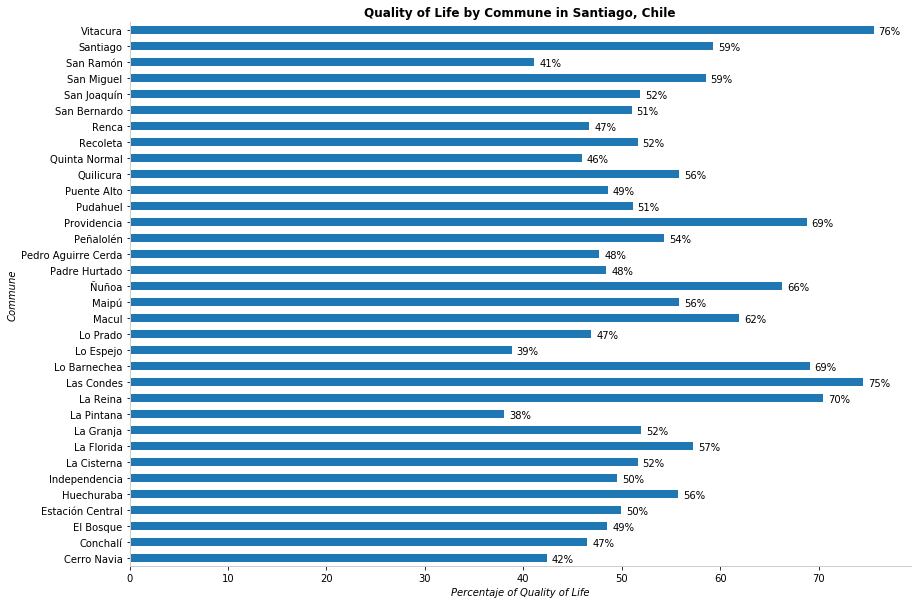

In [19]:
ax = lista['Quality of Life'].plot(kind='barh', figsize=(14, 10))
ax.set_title('Quality of Life by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune',fontstyle='italic')
ax.set_xlabel('Percentaje of Quality of Life',fontstyle='italic')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width +0.5 , p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

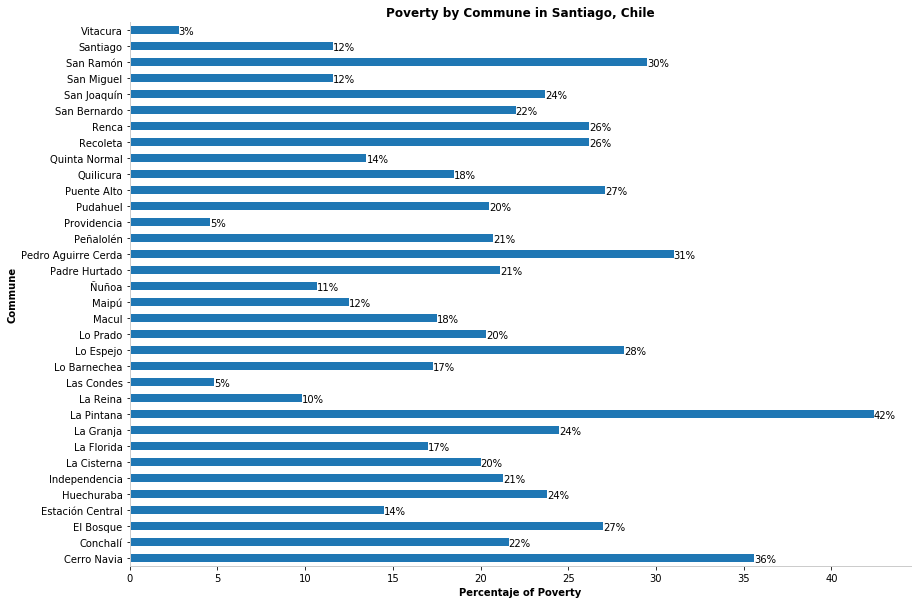

In [20]:
ax = lista['Poverty'].plot(kind='barh', figsize=(14, 10))
ax.set_title('Poverty by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune', weight='bold')
ax.set_xlabel('Percentaje of Poverty', weight='bold')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width, p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

For our analysis we are going to need the communes with higger Quality of Life and less Poverty.

With a histogram we can know the aprox number of communes we are going to analize

Text(0, 0.5, 'Number of Communes')

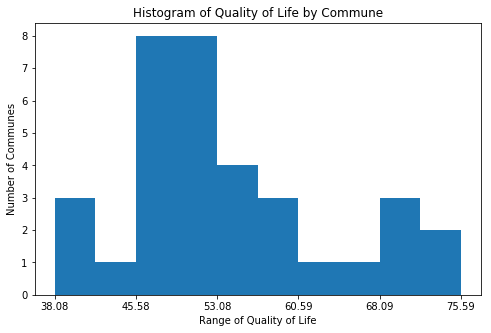

In [21]:
count, bin_edges = np.histogram(lista['Quality of Life'],5)
hist = lista['Quality of Life'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
hist.set_title('Histogram of Quality of Life by Commune')
hist.set_xlabel('Range of Quality of Life')
hist.set_ylabel('Number of Communes')

In [22]:
QoLSorted =lista.sort_values('Quality of Life',ascending=True)

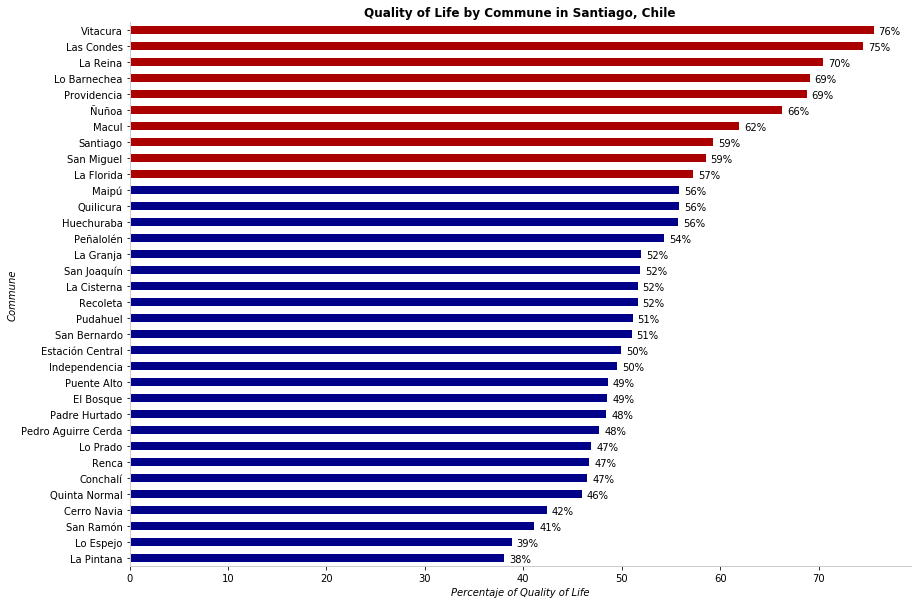

In [23]:
ax = QoLSorted['Quality of Life'].plot(kind='barh', figsize=(14, 10), color=['#AA0000' if row['Quality of Life'] > 57 else '#000088' for name,row in QoLSorted.iterrows()],)
ax.set_title('Quality of Life by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune',fontstyle='italic')
ax.set_xlabel('Percentaje of Quality of Life',fontstyle='italic')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width +0.5 , p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

Text(0, 0.5, 'Number of Communes')

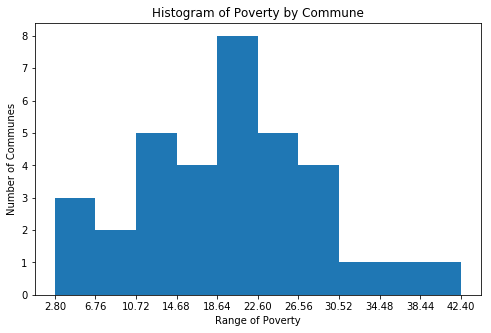

In [24]:
count, bin_edges = np.histogram(lista['Poverty'],10)
hist = lista['Poverty'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
hist.set_title('Histogram of Poverty by Commune')
hist.set_xlabel('Range of Poverty')
hist.set_ylabel('Number of Communes')

In [25]:
PovertySorted =lista.sort_values('Poverty',ascending=False)

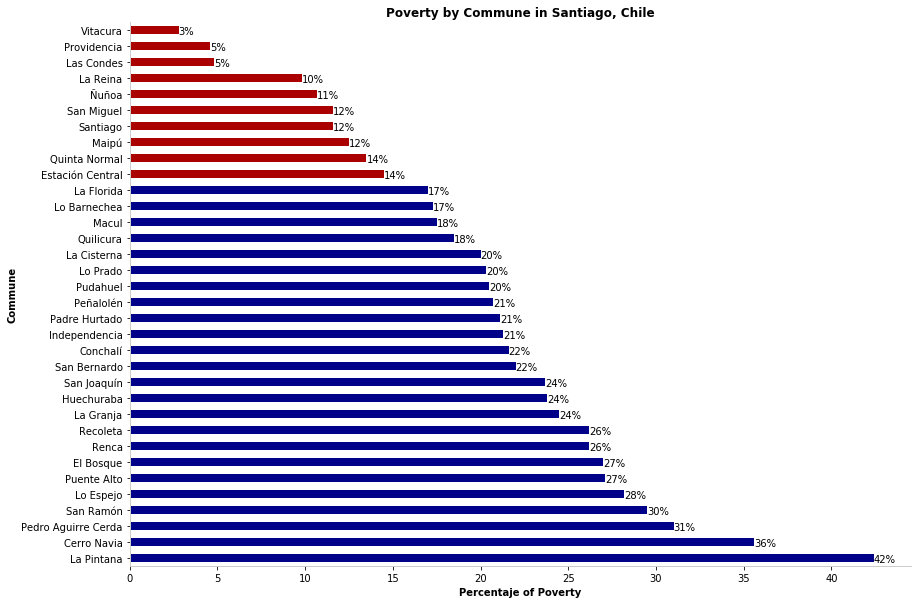

In [26]:
ax = PovertySorted['Poverty'].plot(kind='barh', figsize=(14, 10), color=['#AA0000' if row['Poverty'] < 15 else '#000088' for name,row in PovertySorted.iterrows()],)
ax.set_title('Poverty by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune', weight='bold')
ax.set_xlabel('Percentaje of Poverty', weight='bold')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width, p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

To obtain the latitude and longitude of every commune we are using the geocode HERE

In [27]:
# The code was removed by Watson Studio for sharing.

In [28]:
lista['Latitude']=0
lista['Longitude']=0
for i in range(0, len(lista)):
    ubicacion = '\''+lista.index[i]+',Santiago,Chile\''
    g=geocoder.here(ubicacion,app_id=ID,app_code=CODE) # I'm using the geocoder HERE
   # print(i,"-",ubicacion,':',g.lat,' ',g.lng)
    lista['Latitude'].iloc[i] = g.lat
    lista['Longitude'].iloc[i]= g.lng

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
address = 'Santiago, Chile'
g=geocoder.here(address,app_id=ID,app_code=CODE)
SCL_lat = g.lat
SCL_lng = g.lng
print('The geograpical coordinates of Santiago are {}, {}.'.format(SCL_lat, SCL_lng))

The geograpical coordinates of Santiago are -33.43722, -70.65002.


In [30]:
lista.head()

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
Cerro Navia,norponiente,132622,35.6,42.42,92,-33.43472,-70.72992
Conchalí,norte,126955,21.6,46.52,84,-33.39659,-70.67104
El Bosque,sur,162505,27.0,48.54,70,-33.55567,-70.66590
Estación Central,surponiente,147041,14.5,49.96,64,-33.45101,-70.67941
Huechuraba,norte,98671,23.8,55.70,33,-33.37464,-70.63490


We filter the data by the Quality of Life and Poverty, this sub-dataframes are going to help to choose the communes to analyze

In [31]:
lista_QOL = lista[lista['Quality of Life'] >= 57]
lista_QOL.shape

(10, 7)

In [32]:
lista_QOL

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
La Florida,suroriente,366916,17.0,57.23,22,-33.52185,-70.59863
La Reina,nororiente,92787,9.8,70.45,3,-33.43929,-70.55638
Las Condes,nororiente,294838,4.8,74.54,2,-33.41657,-70.59553
Lo Barnechea,nororiente,105833,17.3,69.09,4,-33.36199,-70.51445
Macul,suroriente,116534,17.5,61.92,8,-33.48178,-70.59921
Ñuñoa,nororiente,208237,10.7,66.28,6,-33.45521,-70.59388
Providencia,nororiente,142079,4.6,68.79,5,-33.43179,-70.60940
San Miguel,sur,107954,11.6,58.53,17,-33.48576,-70.64995
Santiago,centro,404495,11.6,59.27,16,-33.43722,-70.65002
Vitacura,nororiente,85384,2.8,75.59,1,-33.39923,-70.60105


In [33]:
lista_POV = lista[lista['Poverty']<=15]
lista_POV.shape

(10, 7)

In [34]:
lista_POV

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
Estación Central,surponiente,147041,14.5,49.96,64,-33.45101,-70.67941
La Reina,nororiente,92787,9.8,70.45,3,-33.43929,-70.55638
Las Condes,nororiente,294838,4.8,74.54,2,-33.41657,-70.59553
Maipú,surponiente,521627,12.5,55.87,30,-33.51041,-70.75638
Ñuñoa,nororiente,208237,10.7,66.28,6,-33.45521,-70.59388
Providencia,nororiente,142079,4.6,68.79,5,-33.43179,-70.60940
Quinta Normal,norponiente,110026,13.5,45.93,86,-33.42253,-70.69522
San Miguel,sur,107954,11.6,58.53,17,-33.48576,-70.64995
Santiago,centro,404495,11.6,59.27,16,-33.43722,-70.65002
Vitacura,nororiente,85384,2.8,75.59,1,-33.39923,-70.60105


*The following map is going to display all the communes in a blue circle, the communes with better Quality of life in a red cicle and the communes with the less poverty in a yellow circle*

In [35]:
map_santiago = folium.Map(location=[SCL_lat, SCL_lng], zoom_start=11.5)

# add markers to map
for lat, lng, index in zip(lista['Latitude'], lista['Longitude'], lista.index):
    label = index
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)  
    
for lat, lng, label1 in zip(lista_QOL['Latitude'], lista_QOL['Longitude'], lista_QOL['Quality of Life']):
    label = 'QOL: '+format(label1)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#f9c8b8',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)    
    
for lat, lng, label2 in zip(lista_POV['Latitude'], lista_POV['Longitude'], lista_POV['Poverty']):
    label = 'Poverty: '+format(label2)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#f9f8cf',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)    
map_santiago

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Santiago with a good quality of life and low poverty.

Based on the map visualization of the communes and the communes with low poverty and high quality of life we decided what communes to explore. 

The communes with the higher Quality of Life are almost equivalent to the communes with lower poverty, so we can explore the communes with a Quality of Life with more than 50 percent.

With Fourquare we are going to get the venues by commune and clasify it by their categories.

With the categories we can choose the communes with less coffee shops.

As final step we can visualize the choose commune and detect the venues frecuented by young people to recomend the best places to open a coffee shop

## Analysis <a name="analysis"></a>

Based on the communes displayed in the map, I'm going to use the sub-dataframe with the communes with higher Quality of Life

In [36]:
# The code was removed by Watson Studio for sharing.

In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We are going to use the following funtion to obtain the venues per commune in a radius of 2000

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue',
                  'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
lista_QOL.head()

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
La Florida,suroriente,366916,17.0,57.23,22,-33.52185,-70.59863
La Reina,nororiente,92787,9.8,70.45,3,-33.43929,-70.55638
Las Condes,nororiente,294838,4.8,74.54,2,-33.41657,-70.59553
Lo Barnechea,nororiente,105833,17.3,69.09,4,-33.36199,-70.51445
Macul,suroriente,116534,17.5,61.92,8,-33.48178,-70.59921


In [40]:
LIMIT = 500
santiago_venues = getNearbyVenues(names=lista_QOL.index, latitudes=lista_QOL['Latitude'], longitudes=lista_QOL['Longitude'])

La Florida
La Reina
Las Condes
Lo Barnechea
Macul
Ñuñoa
Providencia
San Miguel
Santiago
Vitacura


In [41]:
print(santiago_venues.shape)

(1000, 8)


In [42]:
print('There are {} uniques categories.'.format(len(santiago_venues['Venue Category'].unique())))

There are 200 uniques categories.


In [43]:
# one hot encoding
santiago_onehot = pd.get_dummies(santiago_venues[['Venue Category']], prefix="", prefix_sep="")

santiago_onehot['Commune'] = santiago_venues['Commune'] 

# move commune column to the first column
fixed_columns = [santiago_onehot.columns[-1]] + list(santiago_onehot.columns[:-1])
santiago_onehot = santiago_onehot[fixed_columns]

santiago_onehot.head()

,Commune,Accessories Store,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,La Florida,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,La Florida,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,La Florida,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,La Florida,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,La Florida,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
santiago_onehot.shape

(1000, 201)

In [45]:
santiago_grouped = santiago_onehot.groupby('Commune').mean().reset_index()
santiago_grouped.head()

,Commune,Accessories Store,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,La Florida,0.0,0.00,0.00,0.02,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.01
1,La Reina,0.0,0.02,0.01,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00
2,Las Condes,0.0,0.01,0.00,0.00,0.0,0.01,0.0,0.0,0.0,...,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.01
3,Lo Barnechea,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.00
4,Macul,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,...,0.01,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00


Now we are going to get the top 10 venues for commune

In [46]:
num_top_venues = 10

for hood in santiago_grouped['Commune']:
    print("----"+hood+"----")
    temp = santiago_grouped[santiago_grouped['Commune'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----La Florida----
                 venue  freq
0       Ice Cream Shop  0.08
1     Sushi Restaurant  0.08
2   Chinese Restaurant  0.05
3  Sporting Goods Shop  0.04
4                 Café  0.03
5            Bookstore  0.03
6          Flea Market  0.03
7       Cosmetics Shop  0.03
8             Pharmacy  0.03
9       Sandwich Place  0.03


----La Reina----
                  venue  freq
0           Pizza Place  0.07
1                  Park  0.06
2   Peruvian Restaurant  0.05
3    Chinese Restaurant  0.05
4  Gym / Fitness Center  0.04
5                Bakery  0.04
6             Multiplex  0.03
7        Breakfast Spot  0.03
8      Sushi Restaurant  0.03
9        Sandwich Place  0.03


----Las Condes----
                venue  freq
0               Hotel  0.09
1         Coffee Shop  0.05
2               Plaza  0.04
3  Italian Restaurant  0.04
4         Pizza Place  0.04
5              Bakery  0.04
6                Park  0.03
7        Burger Joint  0.03
8   Indian Restaurant  0.03
9           

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Commune']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
communes_venues_sorted = pd.DataFrame(columns=columns)
communes_venues_sorted['Commune'] = santiago_grouped['Commune']

for ind in np.arange(santiago_grouped.shape[0]):
    communes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

In [49]:
def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """

  if value == 'Café' or value == 'Coffee Shop':
    color = 'red'
  else:
    color = 'black'

  return 'color: %s' % color

In [50]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


(communes_venues_sorted.style
    .applymap(color_negative_red)
    .set_table_styles(styles))

,Commune,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,La Florida,Sushi Restaurant,Ice Cream Shop,Chinese Restaurant,Sporting Goods Shop,Café,Sandwich Place,Cosmetics Shop,Pharmacy,Bookstore,Flea Market
1,La Reina,Pizza Place,Park,Chinese Restaurant,Peruvian Restaurant,Gym / Fitness Center,Bakery,Sushi Restaurant,Multiplex,Sandwich Place,Breakfast Spot
2,Las Condes,Hotel,Coffee Shop,Bakery,Pizza Place,Italian Restaurant,Plaza,Park,Burger Joint,Café,Indian Restaurant
3,Lo Barnechea,Gym,Restaurant,Coffee Shop,Shopping Mall,Burger Joint,Chinese Restaurant,Pharmacy,Historic Site,Sandwich Place,College Gym
4,Macul,Chinese Restaurant,Sandwich Place,Pharmacy,Restaurant,Bakery,Soccer Field,Pizza Place,Peruvian Restaurant,Sushi Restaurant,Flea Market
5,Providencia,Pizza Place,Sandwich Place,Restaurant,French Restaurant,Park,Coffee Shop,Café,Plaza,Burger Joint,Indian Restaurant
6,San Miguel,Restaurant,Sushi Restaurant,Sandwich Place,Peruvian Restaurant,Flea Market,Plaza,Pizza Place,Bakery,Latin American Restaurant,Seafood Restaurant
7,Santiago,Coffee Shop,Hotel,Café,Restaurant,Sandwich Place,Art Museum,Pizza Place,Bookstore,Peruvian Restaurant,Korean Restaurant
8,Vitacura,Hotel,Coffee Shop,Peruvian Restaurant,Restaurant,Ice Cream Shop,Steakhouse,Plaza,Pizza Place,Park,Seafood Restaurant
9,Ñuñoa,Bakery,Café,Restaurant,Coffee Shop,Pizza Place,Yoga Studio,Gym,Peruvian Restaurant,Plaza,Italian Restaurant


So, we have the following communes without coffee shops or Cafés in their top 10
- La Reina
- Macul
- San Miguel

Lets look again the Poverty and Quality of Life indexes of this communes

In [51]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [52]:
def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

In [53]:
lista.loc[['La Reina','Macul','San Miguel','La Florida']].style.apply(highlight_max,subset=['Quality of Life']).apply(highlight_min,subset=['Poverty'])

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
La Reina,nororiente,92787,9.8,70.45,3,-33.4393,-70.5564
Macul,suroriente,116534,17.5,61.92,8,-33.4818,-70.5992
San Miguel,sur,107954,11.6,58.53,17,-33.4858,-70.65
La Florida,suroriente,366916,17,57.23,22,-33.5219,-70.5986


#### La Reina has a better Quality of Life and a less Poverty and based in this criteria we are going to explore this commune

what venue categories are in La Reina?

In [54]:
categories = santiago_venues[(santiago_venues['Commune']=='La Reina')][['Venue','Venue Category']].groupby('Venue Category').count().reset_index()

In [55]:
categories.rename(columns={'Venue':'Count'},inplace=True)

Now we are going to explore the location of the Coffee Shops and Cafes in the commune, also the Bakerys could be a potential competitor

In [56]:
lareina_venues = santiago_venues[((santiago_venues['Commune']=='La Reina'))] 

In [57]:
coffee_venues = santiago_venues[((santiago_venues['Commune']=='La Reina') & ((santiago_venues['Venue Category']=='Coffee Shop') | (santiago_venues['Venue Category']=='Café')| (santiago_venues['Venue Category']=='Bakery')))]

In [58]:
coffee_venues

,Commune,Commune Latitude,Commune Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
104,La Reina,-33.43929,-70.55638,Starbucks,4b6c4086f964a520ca2b2ce3,-33.438917,-70.561624,Coffee Shop
107,La Reina,-33.43929,-70.55638,Wenger Haus,4d03e37d28926ea81e5d68c2,-33.427732,-70.554273,Bakery
119,La Reina,-33.43929,-70.55638,Amasa Bakery,53a4a333498e183ecb1b7d0b,-33.448585,-70.543774,Bakery
139,La Reina,-33.43929,-70.55638,Doña Cata,4c9681f082b56dcb0e36e2aa,-33.431230,-70.571691,Bakery
152,La Reina,-33.43929,-70.55638,Panificadora Rosemary,4db9b6c704376091210935e3,-33.429095,-70.554385,Bakery
175,La Reina,-33.43929,-70.55638,Butterfly Coffee,552945cd498e9b3b1e00f3db,-33.440574,-70.535688,Coffee Shop
184,La Reina,-33.43929,-70.55638,Bogat Caffé,4f4a7093e4b07165fb412094,-33.440274,-70.534866,Café


In [59]:
coffee_venues[['Venue','Venue Category']].reset_index(drop='true')

,Venue,Venue Category
0,Starbucks,Coffee Shop
1,Wenger Haus,Bakery
2,Amasa Bakery,Bakery
3,Doña Cata,Bakery
4,Panificadora Rosemary,Bakery
5,Butterfly Coffee,Coffee Shop
6,Bogat Caffé,Café


Now, we are going to visualize this venues in a map.

In [60]:
latitude =  lista['Latitude'].loc['La Reina']
longitude = lista['Longitude'].loc['La Reina']

In [61]:
map_commune = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, venue in zip(coffee_venues['Venue Latitude'], coffee_venues['Venue Longitude'], coffee_venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_commune)  
map_commune

Based on the venues categories we are going to exclude places like restaurants

In [62]:
my_categories = ['Amphitheater',\
'Athletics & Sports',\
'Bike Rental / Bike Share',\
'Bookstore',\
'Farmers Market',\
'Golf Course',\
'Gym / Fitness Center',\
'Hockey Field',\
'Movie Theater',\
'Multiplex',\
'Music Venue',\
'Other Great Outdoors',\
'Outdoors & Recreation',\
'Park',\
'Plane',\
'Plaza',\
'Shopping Mall',\
'Soccer Field',\
'Sporting Goods Shop']

In [63]:
categories[((categories['Venue Category'].isin(my_categories)))].sort_values(by=['Count']).reset_index(drop=True)

,Venue Category,Count
0,Amphitheater,1
1,Shopping Mall,1
2,Plane,1
3,Other Great Outdoors,1
4,Music Venue,1
5,Movie Theater,1
6,Hockey Field,1
7,Sporting Goods Shop,1
8,Golf Course,1
9,Farmers Market,1


In [64]:
my_venues=lareina_venues[((lareina_venues['Venue Category'].isin(my_categories)))]


In [65]:
my_venues = my_venues.reset_index(drop=True)

Visulize in a map where are located this venues

In [66]:
for lat, lng, venue in zip(my_venues['Venue Latitude'], my_venues['Venue Longitude'], my_venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.3,
        parse_html=False).add_to(map_commune)
map_commune

We can group the markers into different clusters using the MarkerCluster object in the map

In [67]:
from folium import plugins

categories2 = plugins.MarkerCluster().add_to(map_commune)

for lat, lng, label, in zip(my_venues['Venue Latitude'], my_venues['Venue Longitude'], my_venues['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(categories2)

# display map
map_commune

Visually we can identify 3 posibles zones for our Coffee Shop, relatively far from our competirors and with several venues of our interest

For the location, I filter for one of the venues in every zone

In [68]:
zones = ['Cine Hoyts Sala 4DX','Antártica Libros','Plaza Augusto D\'halmar']

In [69]:
my_zones = my_venues[my_venues['Venue'].isin(zones)].reset_index(drop='true')
my_zones = my_zones[['Venue Latitude','Venue Longitude','Venue']]

In [70]:
for x in range(len(zones)):
    my_zones['Venue'].iloc[x]='Zone '+str(x)

In [71]:
my_zones

,Venue Latitude,Venue Longitude,Venue
0,-33.452185,-70.569757,Zone 0
1,-33.437200,-70.577781,Zone 1
2,-33.428290,-70.540476,Zone 2


In [72]:
import folium
from folium.features import DivIcon

In [73]:
for lat, lng, label in zip(my_zones['Venue Latitude'], my_zones['Venue Longitude'],my_zones['Venue']):
    folium.CircleMarker(
        [lat, lng],
        radius=100,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.3,
        parse_html=False).add_to(map_commune) 
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 16pt">%s</div>' % label,
        )
    ).add_to(map_commune)
map_commune

For more concrete results, lets explore the venues in a radius of 500 meters of every posibly location.

In [74]:
explore_venues = getNearbyVenues(names=my_zones['Venue'], latitudes=my_zones['Venue Latitude'], longitudes=my_zones['Venue Longitude'], radius=500)

Zone 0
Zone 1
Zone 2


And we also can obtain the top ten venues near to get a better understanding of the kind of venues located in the zone

In [75]:
# one hot encoding
lareina_onehot = pd.get_dummies(explore_venues[['Venue Category']], prefix="", prefix_sep="")

lareina_onehot['Venue'] = explore_venues['Commune'] 

# move commune column to the first column
fixed_columns = [lareina_onehot.columns[-1]] + list(lareina_onehot.columns[:-1])
lareina_onehot = lareina_onehot[fixed_columns]

lareina_onehot.head()

,Venue,American Restaurant,Amphitheater,Asian Restaurant,Bakery,Bike Rental / Bike Share,Bookstore,Brewery,Burger Joint,Bus Station,...,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Theme Park,Tourist Information Center,Toy / Game Store,Tree,Women's Store
0,Zone 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Zone 0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Zone 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Zone 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Zone 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
lareina_grouped = lareina_onehot.groupby('Venue').mean().reset_index()
lareina_grouped.head()

,Venue,American Restaurant,Amphitheater,Asian Restaurant,Bakery,Bike Rental / Bike Share,Bookstore,Brewery,Burger Joint,Bus Station,...,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Theme Park,Tourist Information Center,Toy / Game Store,Tree,Women's Store
0,Zone 0,0.025,0.025,0.000000,0.075000,0.025,0.025000,0.000000,0.025,0.000000,...,0.025,0.025000,0.05,0.000000,0.025,0.025,0.000000,0.025,0.000000,0.000000
1,Zone 1,0.000,0.000,0.052632,0.052632,0.000,0.000000,0.000000,0.000,0.052632,...,0.000,0.000000,0.00,0.000000,0.000,0.000,0.000000,0.000,0.052632,0.000000
2,Zone 2,0.000,0.000,0.000000,0.000000,0.000,0.038462,0.038462,0.000,0.000000,...,0.000,0.038462,0.00,0.038462,0.000,0.000,0.115385,0.000,0.000000,0.038462


In [77]:
num_top_venues = 10

for hood in lareina_grouped['Venue']:
#    print("----"+hood+"----")
    temp = lareina_grouped[lareina_grouped['Venue'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
#   print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#   print('\n')

In [78]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Venue']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Venue'] = lareina_grouped['Venue']

for ind in np.arange(lareina_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(lareina_grouped.iloc[ind, :], num_top_venues)

In [79]:
def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """

  if value == 'Café' or value == 'Coffee Shop' or value =='Bakery':
        color = 'red'
  else:
    if value in my_categories:
        color = 'blue'
    else:
        color = 'black'

  return 'color: %s' % color



In [80]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


(venues_sorted.style
    .applymap(color_negative_red)
    .set_table_styles(styles))

,Venue,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zone 0,Bakery,Coffee Shop,Sushi Restaurant,Clothing Store,Multiplex,Frozen Yogurt Shop,Massage Studio,Latin American Restaurant,Italian Restaurant,Ice Cream Shop
1,Zone 1,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Plaza,Park,Pie Shop,Pizza Place,Gym / Fitness Center,Food & Drink Shop,Bus Station
2,Zone 2,Tourist Information Center,Pharmacy,Sporting Goods Shop,Soccer Field,Women's Store,Shopping Mall,Nail Salon,Candy Store,Furniture / Home Store,Ice Cream Shop


This concludes our analysis we have identified 3 possibly zones viable for open a new Coffee Shop

## Results and Discussion <a name="results"></a>

Our Analisys shows there are still zones in Santiago with not many coffee shops and this zones could have a potential for open a new Speacialty Coffee Shop.

To detect the potential zones, first we aislated the zones with better quality of life and less poverty and using the Foursquare API we found that "La Reina" commune was the more suitable for our objective because it doesn't have any Coffee Shops or Cafes in their top 10 venues, also this commune has a better Quality of Life index and Poverty than the other two communes without coffee shops in their top 10 venues.

With a commune in mind we explored the different venues categories of the commune, we detected our posible competitors and the other venues that could be frecuented by the target public of the Coffee Shop like cinemas, parks, librarys, etc.

Using a map visualizacion we located our posible competitors and visualy we could cluster 3 posible zones for our objective, relatively far from the competitors and near several venues of interest.


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the best location to open a Specialty Coffee Shop in Santiago. 

With the exploration of venues in all the city, gradually we could aislate a 3 zones viables for our purpose.  

Our target was determined by the socioeconomics indicatos of the communes of Santiago and the density of Coffee Shops in the different zones of Santiago.

this is an aproximation for the best location, the final decission must be made by stakeholders After analyzing the recommended areas, a market study is needed and see if there are places to lease near these 3 locations